In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import os

## 2. Load the Trained Model

In [11]:
model = load_model("/content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_final.h5")

## 3. Class Labels (Manually Defined)

In [12]:
class_labels = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Pepper,_bell___healthy"
]

## 4. Grad-CAM Utility Function

In [13]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## 5. Superimpose Heatmap on Original Image

In [14]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * alpha + img

    cv2.imwrite(cam_path, superimposed_img)

    # Display
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))

    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    im1 = ax[1].imshow(heatmap, cmap='jet')
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis('off')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    ax[2].imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    ax[2].set_title("Grad-CAM Overlay")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Display what colors mean
    print("Color Intensity Key for Grad-CAM Heatmap:")
    print("Blue: Low Activation (Low Importance)")
    print("Green: Medium Activation")
    print("Yellow: Higher Activation")
    print("Red: High Activation (High Importance)")

## 6. Predict & Visualize with Grad-CAM

In [15]:
def gradcam_on_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # EfficientNet Preprocessing

    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])

    print(f"Predicted Class: {class_labels[pred_class]} ({100*np.max(preds[0]):.2f}%)")

    # EfficientNetB0 last convolutional layer
    last_conv_layer_name = "top_activation"  # can change this depending on the exact layer i want

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    save_and_display_gradcam(img_path, heatmap)

## 7. Run Grad-CAM on a Sample Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted Class: Apple___Cedar_apple_rust (61.19%)


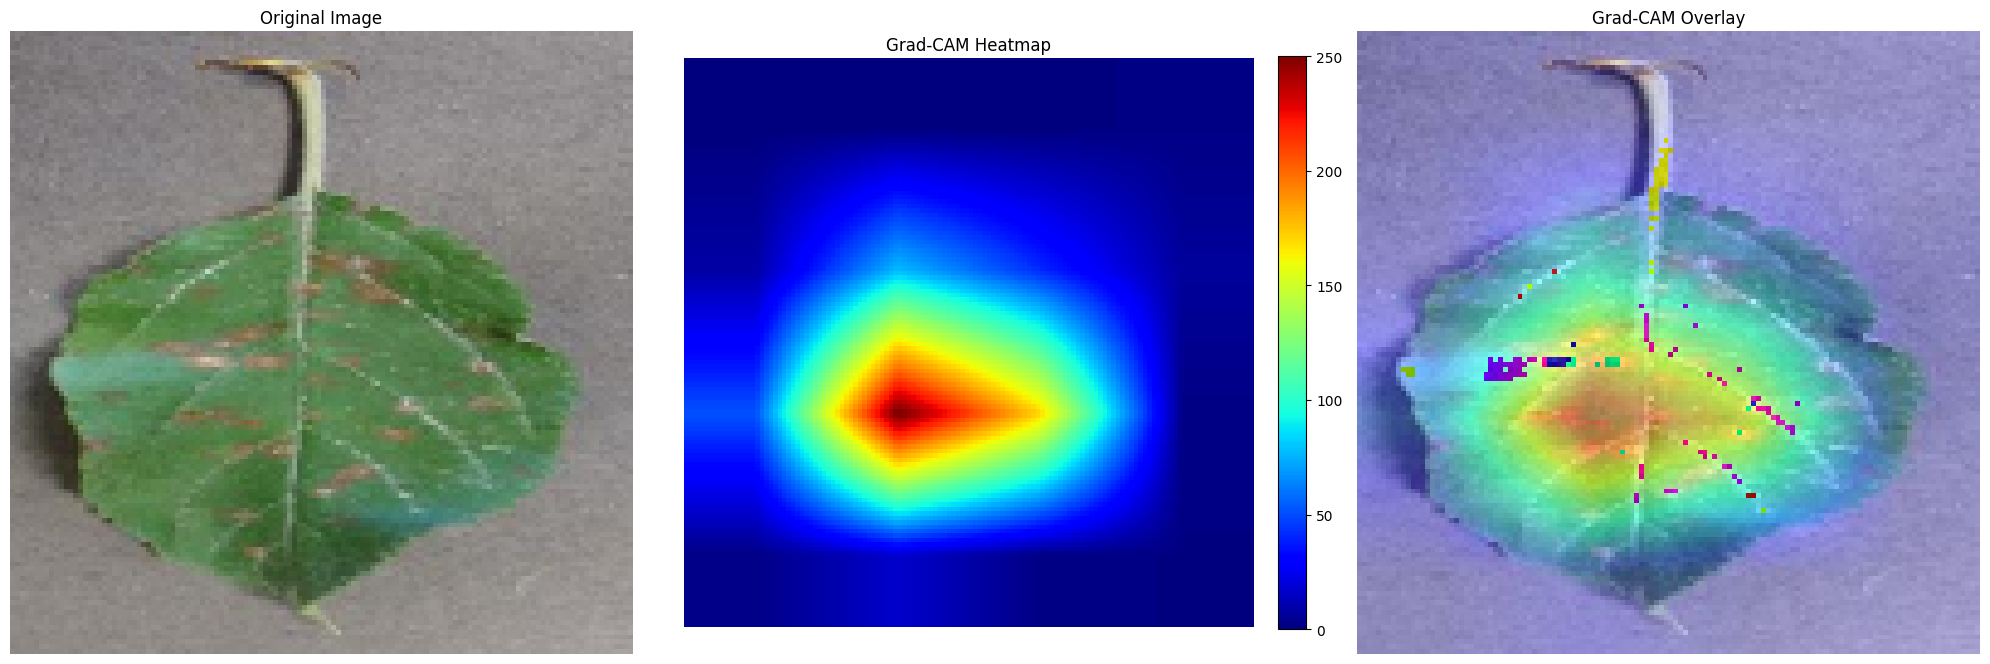

Color Intensity Key for Grad-CAM Heatmap:
Blue: Low Activation (Low Importance)
Green: Medium Activation
Yellow: Higher Activation
Red: High Activation (High Importance)


In [16]:
test_img_path = "/content/drive/My Drive/My_Plant_Proj/Dataset/sample.jpg"
gradcam_on_image(test_img_path)
